In [9]:
from __future__ import print_function
import requests
import sys
import io
import json
import shutil
import sys
import datetime
import subprocess
import sys
import os
import math
import base64
from time import gmtime, strftime
import random, string
import time
import psutil
import base64
import uuid
import socket
import os
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
import torch
from torchvision import transforms
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from pymilvus import MilvusClient
import os
from IPython.display import display
import os
from pymilvus import model
from pymilvus.model.dense import SentenceTransformerEmbeddingFunction

model = SentenceTransformerEmbeddingFunction('all-MiniLM-L6-v2',device='cpu' )

In [10]:
# -----------------------------------------------------------------------------

class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

In [11]:
extractor = FeatureExtractor("resnet34")


In [12]:
# Milvus Constants
COLLECTION_NAME = 'nycstreetcameras'  # Collection name
MILVUS_URL = "http://192.168.1.153:19530" 

In [13]:
# -----------------------------------------------------------------------------
# Connect to Milvus

# Local Docker Server
milvus_client = MilvusClient( uri=MILVUS_URL)

In [17]:
query_image = "street1.png"

results = milvus_client.search(
    COLLECTION_NAME,
    anns_field="image_vector",
    data=[extractor(query_image)],
    output_fields=["filepath", "url", "videourl", "roadwayname", "name", "latlong","weathername", "metar","temperature","weatherdetails" , "directionoftravel", "id"],
    search_params={"metric_type": "COSINE"},
)

[{'id': 451730705222771343, 'distance': 0.737191915512085, 'entity': {'id': 451730705222771343, 'filepath': 'camimages/yolo526f02df-16ee-4e52-9437-010c4e6bbcfd.png', 'name': 'I-495 at Shelter Rock Rd', 'temperature': 82.0, 'directionoftravel': 'Eastbound', 'weathername': 'New York, Kennedy International Airport', 'metar': 'KJFK', 'weatherdetails': 'The current weather observation for New York, Kennedy International Airport[KJFK] in NY @ 40.774248,-73.670624 for 23 Aug 13:51 pm EDT is A Few Clouds with a temperature of 82F, a dew point of 54 and relative humidity of 38% with a wind speed of 3999 with a visibility of 10.00 at an elevation of 197 and an altimeter reading of 1024.9 for the North Hills NY area.', 'url': 'https://511ny.org/map/Cctv/1869--1#20240823181335_b3054695-17cc-4f21-ad55-b9b8c227a42d', 'videourl': 'https://s52.nysdot.skyvdn.com:443/rtplive/R10_013/playlist.m3u8', 'roadwayname': 'I-495', 'latlong': '40.774248,-73.670624'}}, {'id': 451730705222771347, 'distance': 0.7134

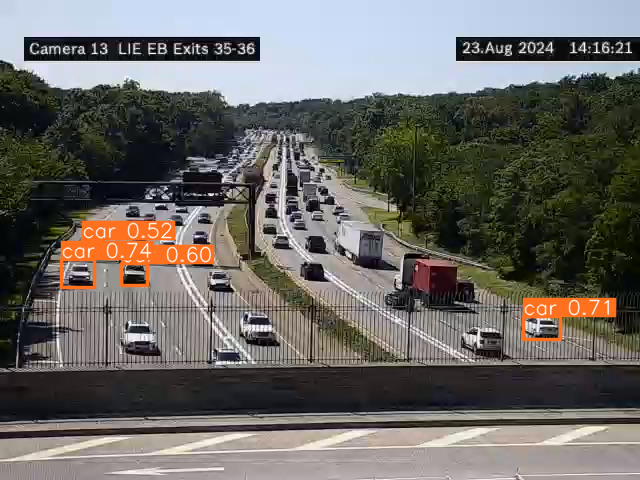

camimages/yolo587de0e4-c3d6-4885-95b1-08dd49d7d6b4.png
I-495


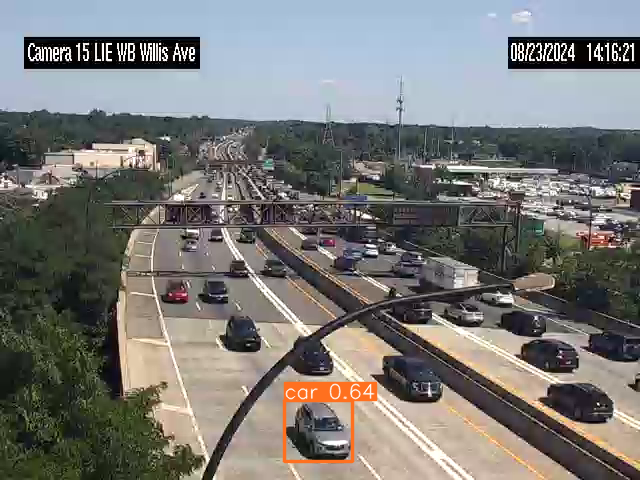

camimages/yolo29033a04-6b0d-484d-a7ab-6015751d3a3f.png
I-495


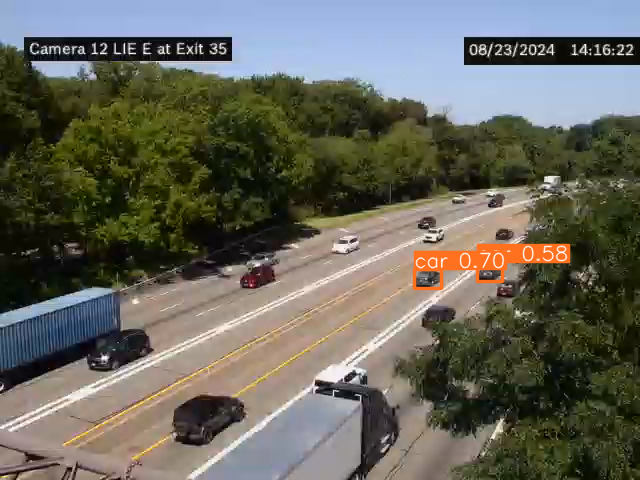

camimages/yolo41bf6b7a-6d58-4af4-b39b-2c1f802997d0.png
I-495


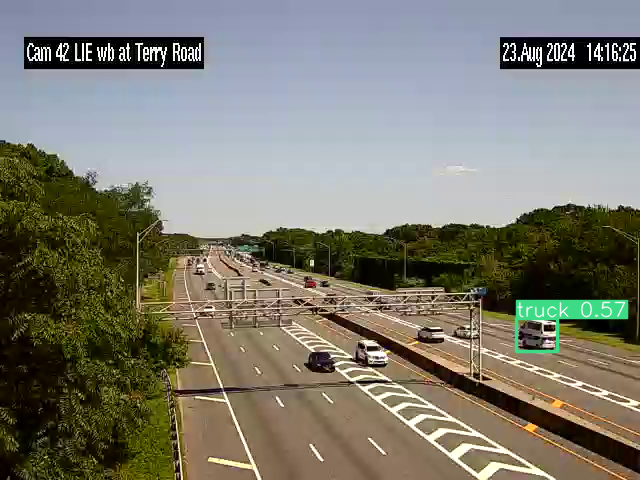

camimages/yolo3f53d60a-5a5f-4994-96e3-e877dd6d0658.png
I-495


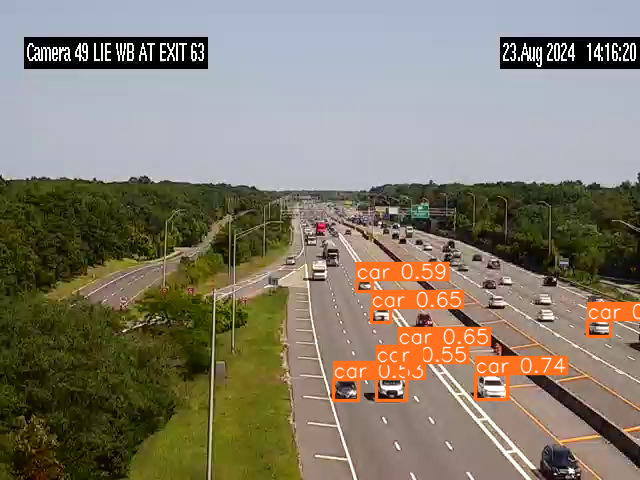

camimages/20240823181155_28c36353-f4b2-438a-be63-a855cadcdd86.png
I-495


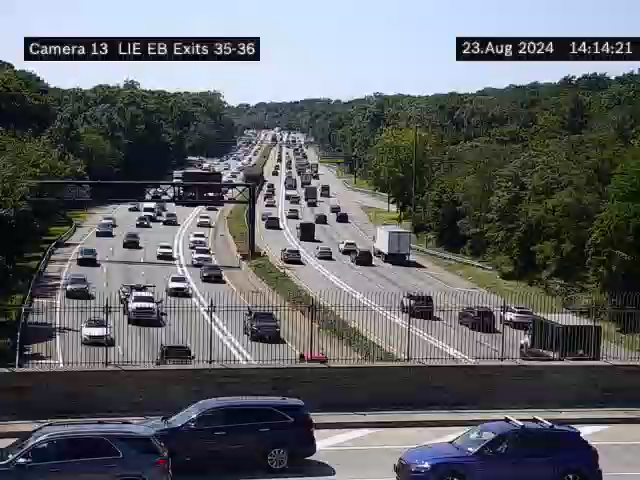

camimages/yolo2a13e64e-b763-433f-aada-e93bceb648eb.png
I-495


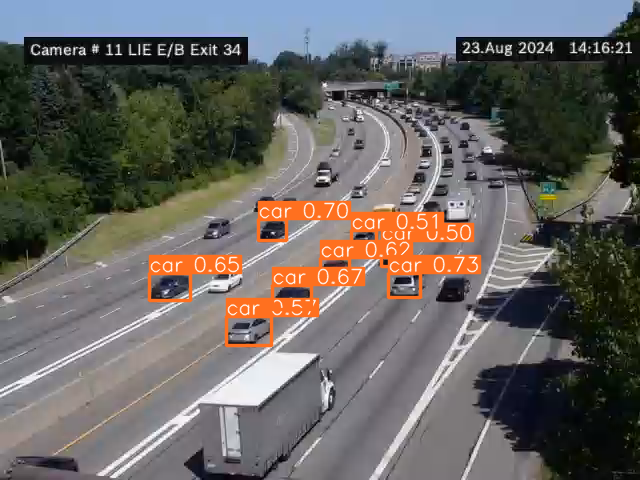

camimages/yolo9e130021-01ec-45db-9343-f205a4dcb3e5.png
I-495


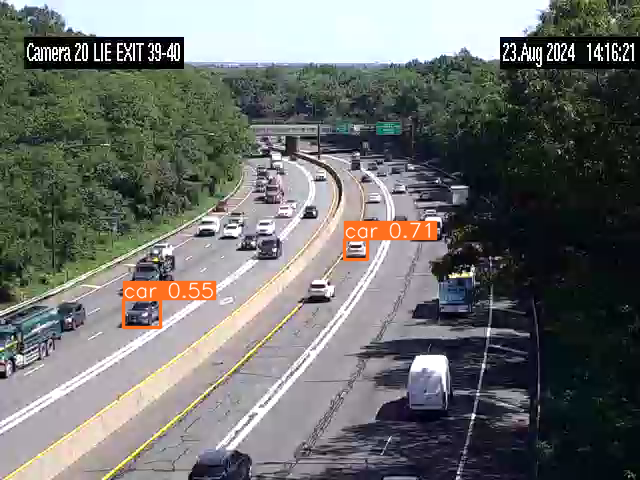

camimages/yolo07bc4cc0-25de-42b2-9732-32826b06c07d.png
I-495


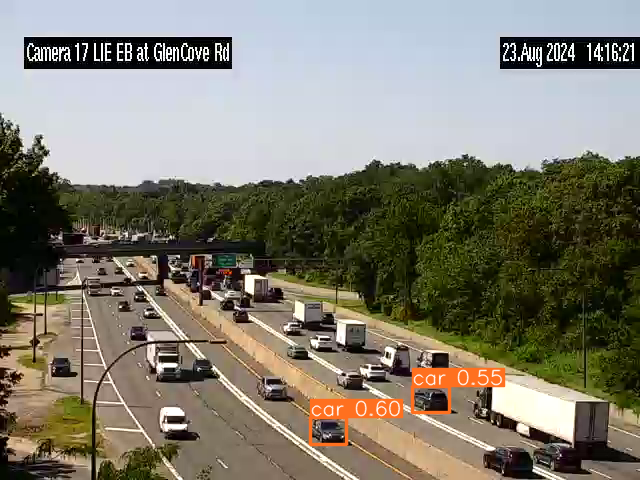

camimages/20240823153631_9620a1ca-711b-46e0-bf95-0d69ff1cc4d5.png
I-495


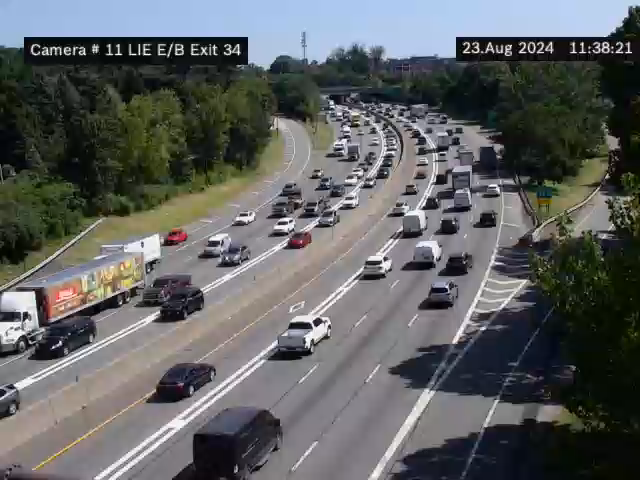

In [18]:
images = []
for result in results:
    print(result)
    for hit in result[:10]:
        filepath = hit["entity"]["filepath"]
        img = Image.open(filepath)
        print(filepath)
        print(hit["entity"]["roadwayname"])
        display(img)

In [76]:
from pymilvus import (
    connections,
    db,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    utility
)
from typing import List, Tuple
connections.connect(
    alias="default", 
    host="192.168.1.153",
    port="19530"
)

fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='latlong', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='name', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='roadwayname', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='directionoftravel', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='videourl', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='url', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='creationdate', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='areadescription', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='elevation', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='county', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='metar', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='weatherid', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='weathername', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='observationdate', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='temperature', dtype=DataType.FLOAT), 
    FieldSchema(name='dewpoint', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='relativehumidity', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='windspeed', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='winddirection', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='gust', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='weather', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='visibility', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='altimeter', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='slp', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='timezone', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='state', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='windchill', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='weatherdetails', dtype=DataType.VARCHAR, max_length=8000),    
    FieldSchema(name='image_vector', dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name='weather_text_vector', dtype=DataType.FLOAT_VECTOR, dim=384)
]

schema = CollectionSchema(fields=fields,enable_dynamic_field=False)

# Create collection
collection = Collection(name=COLLECTION_NAME, schema=schema)
    
# Create index for each vector field
index_params = {
    "metric_type": "L2",
    "index_type": "IVF_FLAT",
    "params": {"nlist": 128},
}

index_params2 = {
    "metric_type": "COSINE"
}

index_params3 = {
    "index_type": "STL_SORT"
}

#collection.create_index("weather_text_vector", index_params)
#collection.create_index("image_vector", index_params2)
#collection.create_index("id", index_params3)


In [77]:
from pymilvus import AnnSearchRequest, RRFRanker, WeightedRanker

query_WeatherVector = "The current weather observation for New York, Kennedy International Airport[KJFK] in NY @ 40.767013,-73.696306 for is A Few Clouds with a temperature of  "
query_ImageVector = "camimages/yolo526f02df-16ee-4e52-9437-010c4e6bbcfd.png"

search_param_0 = {
    "data": [extractor(query_ImageVector)], # Query vector
    "anns_field": "image_vector", # Vector field name
    "param": {
        "metric_type": "COSINE", # This parameter value must be identical to the one used in the collection schema
    },
    "limit": 5 # Number of search results to return in this AnnSearchRequest
}


request_0 = AnnSearchRequest(**search_param_0)

search_param_1 = {
    "data": [model(query_WeatherVector)], # Query vector
    "anns_field": "weather_text_vector", # Vector field name
    "param": {
        "metric_type": "L2", # This parameter value must be identical to the one used in the collection schema
        "params": {"nprobe": 10}
    },
    "limit": 5 # Number of search results to return in this AnnSearchRequest
}
    
request_1 = AnnSearchRequest(**search_param_1)

reqs = [request_0, request_1]
# Rerank by RRF strategy
rerank = RRFRanker(k=60)

collection.load()

res = collection.hybrid_search(
    reqs, # List of AnnSearchRequests created in step 1
    rerank, # Reranking strategy specified in step 2
    output_fields=["id","latlong","name","roadwayname","directionoftravel","videourl","url","filepath",
    "creationdate","areadescription","elevation","county","metar","weatherid","weathername","observationdate","temperature","dewpoint",
    "relativehumidity","windspeed","winddirection","gust","weather","visibility","altimeter","slp",
   "timezone","state","windchill","weatherdetails"],
    limit=3 # Number of final search results to return
)

# print(res)

Distance:0.737191915512085
camimages/yolo526f02df-16ee-4e52-9437-010c4e6bbcfd.png
I-495
New York, Kennedy International Airport


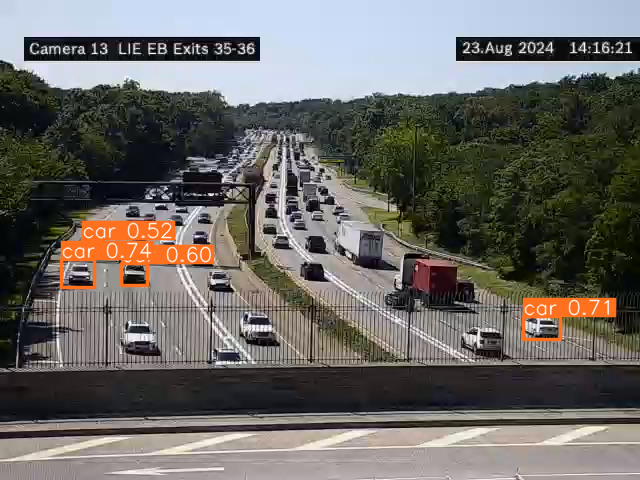

Distance:0.7134350538253784
camimages/yolo587de0e4-c3d6-4885-95b1-08dd49d7d6b4.png
I-495
New York, Kennedy International Airport


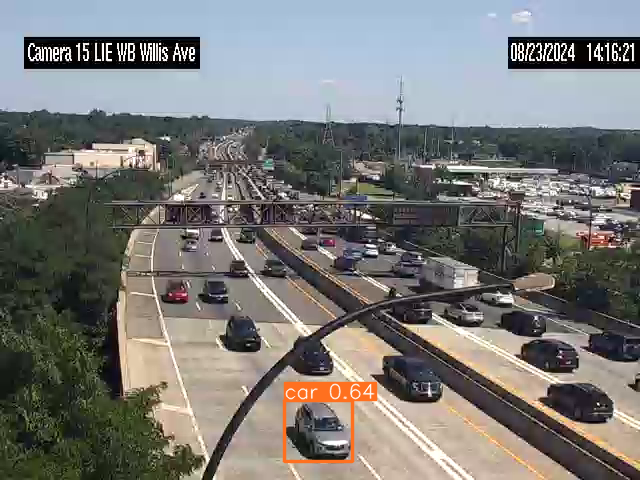

Distance:0.7124178409576416
camimages/yolo29033a04-6b0d-484d-a7ab-6015751d3a3f.png
I-495
New York, Kennedy International Airport


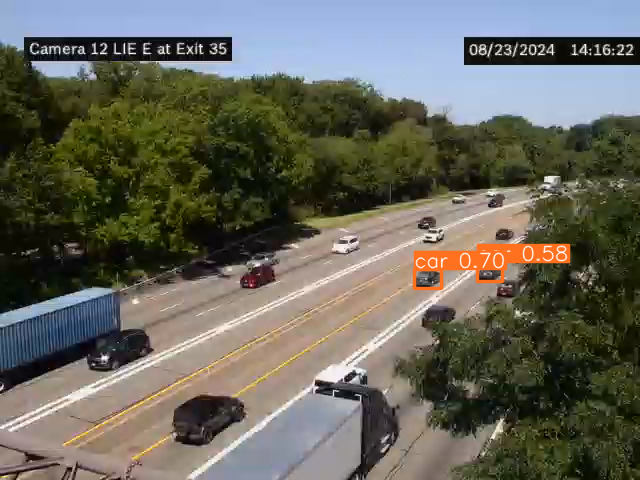

In [85]:
# retrieved_images = []
for result in results:
    # print(result)
    
    for hit in result[:3]:
        # print(hit)
        print("Distance:" + str(hit["distance"]) )
        filepath = hit["entity"]["filepath"]
        img = Image.open(filepath)
        # retrieved_images.append("/Users/timothyspann/Downloads/code/" + filepath)
        print(filepath)
        print(hit["entity"]["roadwayname"])
        print(hit["entity"]["weathername"])
        display(img)